In [8]:
from localreg import *
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import re
from matplotlib.lines import Line2D
from matplotlib import gridspec
from numpy import diff
import csv
rom sklearn.isotonic import IsotonicRegression

A quick function for lowess smoothing of cM values to get rid of noise:

In [465]:
def lowess_smooth_link(df, sextype):
    start = 0.15
    smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=df["phys"].astype(int), endog=df[sextype].astype(float), frac = start))
    smoothed.columns = ["phys", sextype]
    while start < 1:
        if smoothed[sextype].is_monotonic_increasing:
            break
        else:
            start = start + 0.05
            smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=df["phys"].astype(int), endog=df[sextype].astype(float), frac = start))
            smoothed.columns = ["phys", sextype]
    smoothed = smoothed.sort_values("phys").reset_index(drop=True)
    smoothed.loc[smoothed[sextype] < 0, sextype] = 0
    df["smoothed_" + sextype] = smoothed[sextype]
    df["lowess_smoothing_fraction_" + sextype] = start
    df = df.sort_values("phys").reset_index(drop=True)

No MareyMaps are output by default in Lep-MAP3 only mode so we'll make some pretty ones here now:


In [3]:
%%bash
zcat ../linkage_map/lepwrap_apal/2_Filtering/data.filtered.lepmap3.gz \
    | cut -f1,2 | awk '(NR>=7)' > ../linkage_map/lepwrap_apal/snps.txt

In [4]:
snps = pd.read_csv("../linkage_map/lepwrap_apal/snps.txt", sep = "\t")
snps = snps.reset_index(drop=False)
snps.columns = ["Marker", "CHR", "POS"]
snps["Marker"] = snps["Marker"] + 1

Generating input for MareyMap:

In [37]:
apal = pd.DataFrame()
for parts in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]:
    tmp = pd.read_csv("../linkage_map/lepwrap_apal/7_Distances/ordered." + str(parts) + ".distances", 
                sep = "\t", comment = "#", names =  ["Marker", "MALE", "FEMALE", 0, 1])
    tmp = tmp.merge(snps, how = "left", on = "Marker")
    sexavg = pd.read_csv("../linkage_map/lepwrap_apal/7_DistancesSexAverage/ordered." + str(parts) + ".sexavg", 
                sep = "\t", comment = "#", names =  ["Marker", "average", 0, 1, 2])
    sexavg = sexavg.merge(snps, how = "left", on = "Marker")
    tmp["SEXAVG"] = sexavg["average"]
    tmp = tmp[["CHR", "POS", "MALE", "FEMALE", "SEXAVG"]]
    tmp = tmp[tmp["CHR"] == pd.DataFrame(tmp["CHR"].value_counts().head(1)).index[0]].reset_index(drop=True)
    apal = pd.concat([apal, tmp]).reset_index(drop=True)
apal = apal.sort_values(["CHR", "POS"]).reset_index(drop=True)
apal["Marker"] = apal["CHR"] + "_" + apal["POS"].astype(int).astype(str)

In [41]:
apal_corrected = pd.DataFrame()
for chromo in apal["CHR"].unique():
    tmp = apal[apal["CHR"] == chromo].reset_index(drop=True)
    tmp = tmp.sort_values("POS", ascending = True)
    if tmp["SEXAVG"][len(tmp) - 1] < tmp["SEXAVG"][0]:
        tmp["SEXAVG_corrected"] = abs(tmp["SEXAVG"] - tmp["SEXAVG"].max())
        tmp["MALE_corrected"] = abs(tmp["MALE"] - tmp["MALE"].max())
        tmp["FEMALE_corrected"] = abs(tmp["FEMALE"] - tmp["FEMALE"].max())
    else:
        tmp["SEXAVG_corrected"] = tmp["SEXAVG"]
        tmp["MALE_corrected"] = tmp["MALE"]
        tmp["FEMALE_corrected"] = tmp["FEMALE"]
    apal_corrected = pd.concat([apal_corrected, tmp]).reset_index(drop=True)

In [45]:
apal = apal_corrected

In [46]:
for sex in ["MALE", "FEMALE", "SEXAVG"]:
    apal["POS"] = apal["POS"].astype(int)
    apal["Marker"] = apal["CHR"] + "_" + apal["POS"].astype(str)
    apal["set"] = "Acropora palmata"
    tmp = apal[["set", "CHR", "Marker", "POS", sex + "_corrected"]]
    tmp.columns = ["set", "map", "mkr", "phys", "gen"]
    tmp["map"] = tmp["map"].astype(str)
    tmp["mkr"] = tmp["mkr"].astype(str)
    tmp.set_index("set").to_csv("../linkage_map/apal_" + sex + ".txt", sep = " ", quoting=csv.QUOTE_NONNUMERIC)

/tmp/ipykernel_198311/2453814144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["map"] = tmp["map"].astype(str)
/tmp/ipykernel_198311/2453814144.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["mkr"] = tmp["mkr"].astype(str)
/tmp/ipykernel_198311/2453814144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [12]:
fullmap = []
malemap = []
femalemap = []
for i in apal["CHR"].unique():
    malemap = malemap + [apal["FEMALE"][apal["CHR"] == i].max()]
    fullmap = fullmap + [apal["SEXAVG"][apal["CHR"] == i].max()]
    femalemap = femalemap + [apal["MALE"][apal["CHR"] == i].max()]
    print(i, str(apal["FEMALE"][apal["CHR"] == i].max()) + "cM", len(apal["FEMALE"][apal["CHR"] == i]),
          str(apal["SEXAVG"][apal["CHR"] == i].max()) + "cM", len(apal["SEXAVG"][apal["CHR"] == i]),
          str(apal["MALE"][apal["CHR"] == i].max()) + "cM", len(apal["MALE"][apal["CHR"] == i]),)
print(sum(malemap))
print(sum(fullmap))
print(sum(femalemap))

OZ034921 57.841cM 363 102.712cM 363 149.364cM 363
OZ034922 40.105cM 205 74.879cM 205 110.197cM 205
OZ034923 43.099cM 221 74.856cM 221 107.19cM 221
OZ034924 50.799cM 182 86.424cM 182 122.593cM 182
OZ034925 36.64cM 201 64.964cM 201 93.983cM 201
OZ034926 36.309cM 191 72.515cM 191 109.301cM 191
OZ034927 52.813cM 136 82.571cM 136 116.552cM 136
OZ034928 24.79cM 154 50.563cM 154 76.831cM 154
OZ034929 59.145cM 183 81.685cM 183 105.577cM 183
OZ034930 36.257cM 251 62.455cM 251 89.054cM 251
OZ034931 31.568cM 193 68.759cM 193 106.461cM 193
OZ034932 43.165cM 104 67.366cM 104 93.006cM 104
OZ034933 30.826cM 143 57.885cM 143 86.651cM 143
OZ034934 59.567cM 175 78.324cM 175 98.465cM 175
602.924
1025.9579999999999
1465.2250000000001


After visually inspecting MareyMaps, we interactively removed visually aberrant points in the online Shiny app (https://lbbe-shiny.univ-lyon1.fr/MareyMapOnline/). From there, we load the sex-averaged map back in here, generate dummy points using an isotonic regression, and then smooth those dummy points using lowess.

In [481]:
apal = pd.read_csv("../linkage_map/dataCuration_Acroporapalmata_2024-06-27.txt", sep = " ")

/tmp/ipykernel_198311/2831907520.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = apal[apal["map"] == i][apal["vld"] == True].reset_index(drop=True)
/tmp/ipykernel_198311/2831907520.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = apal[apal["map"] == i][apal["vld"] == True].reset_index(drop=True)
/tmp/ipykernel_198311/2831907520.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = apal[apal["map"] == i][apal["vld"] == True].reset_index(drop=True)
/tmp/ipykernel_198311/2831907520.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = apal[apal["map"] == i][apal["vld"] == True].reset_index(drop=True)
/tmp/ipykernel_198311/2831907520.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = apal[apal["map"] == i][apal["vld"] == True].reset_index(drop=True)
/tmp/ipykernel_198311/2831907520.py:3: UserWarning

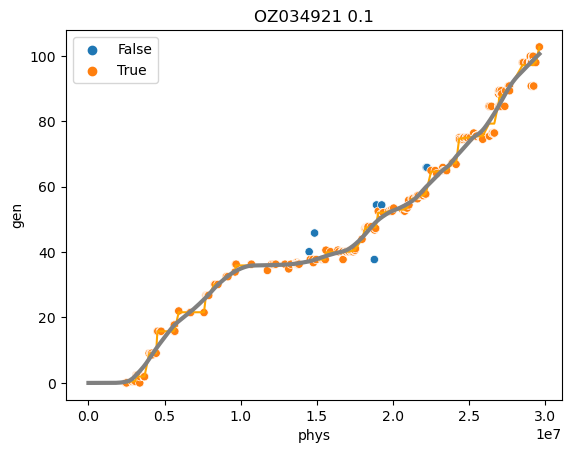

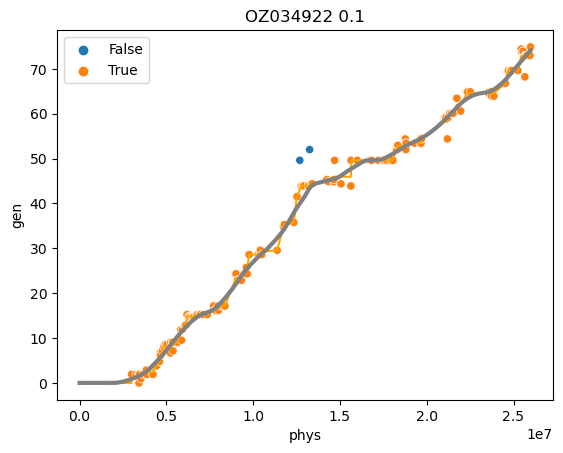

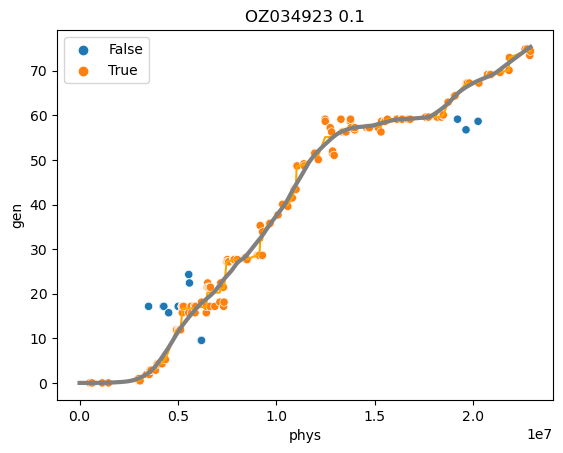

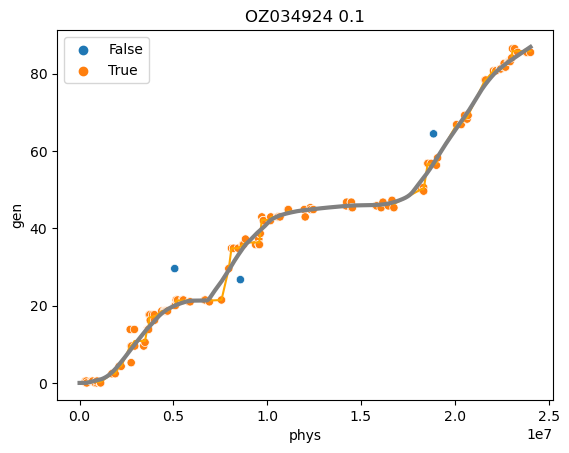

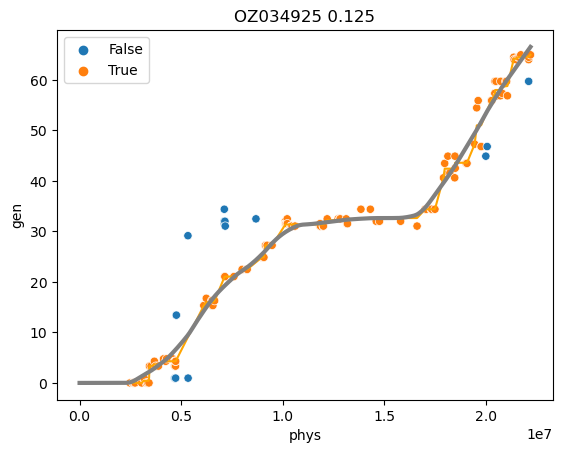

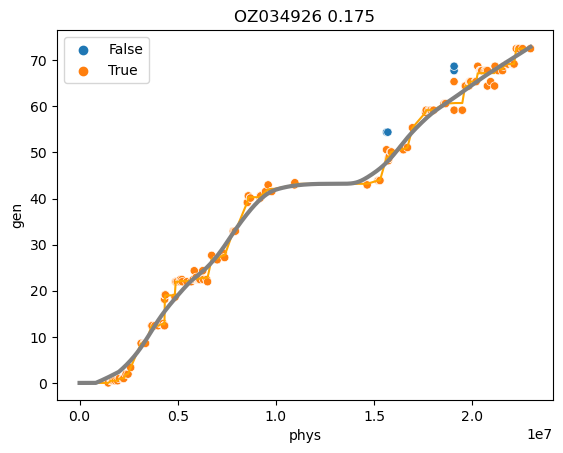

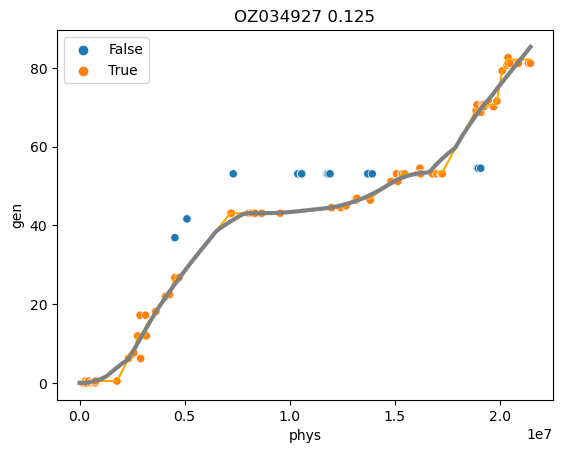

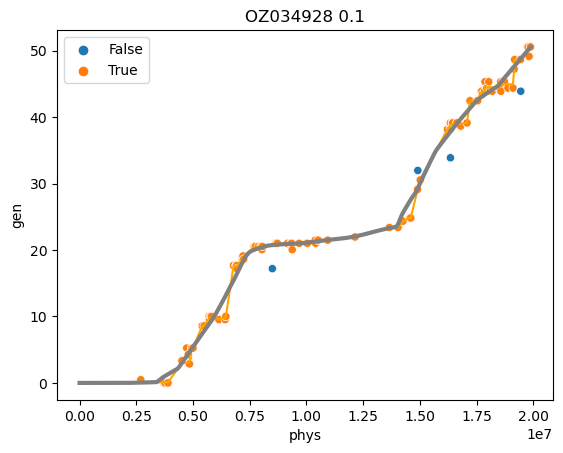

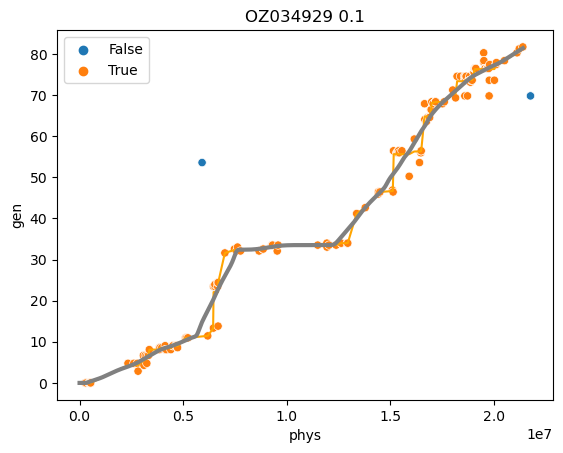

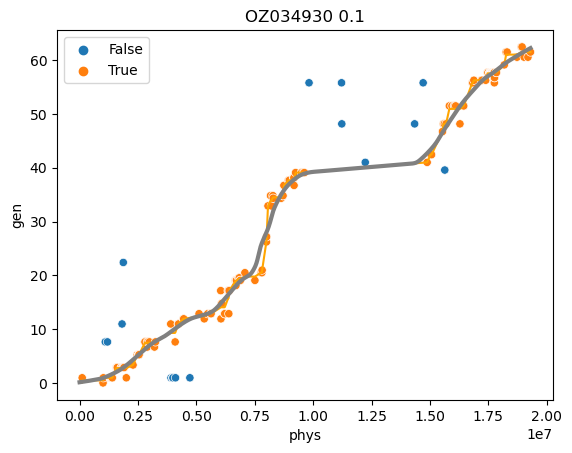

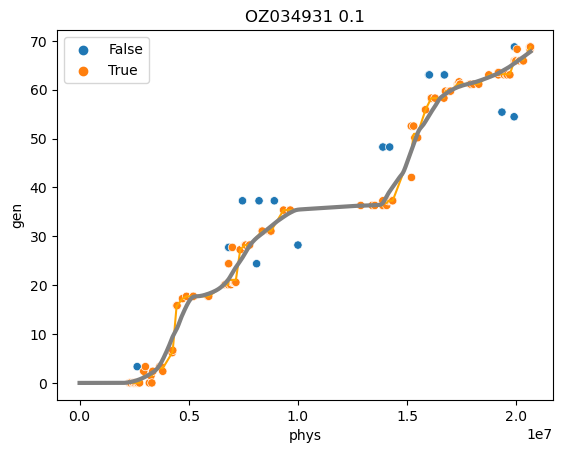

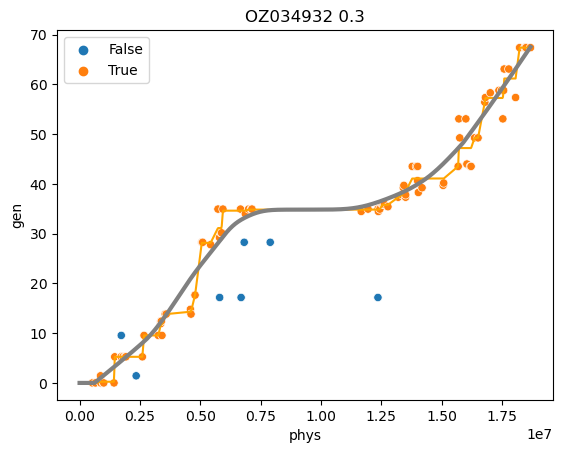

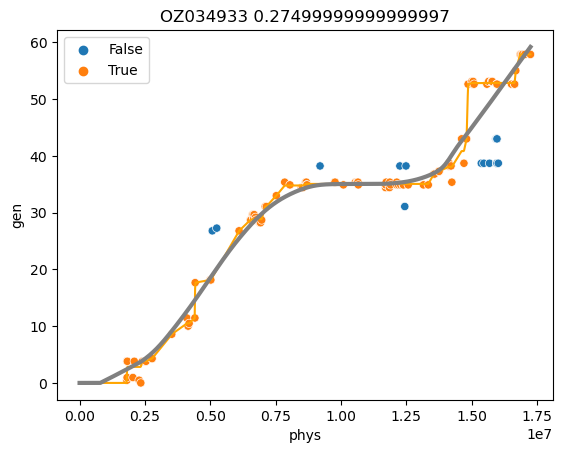

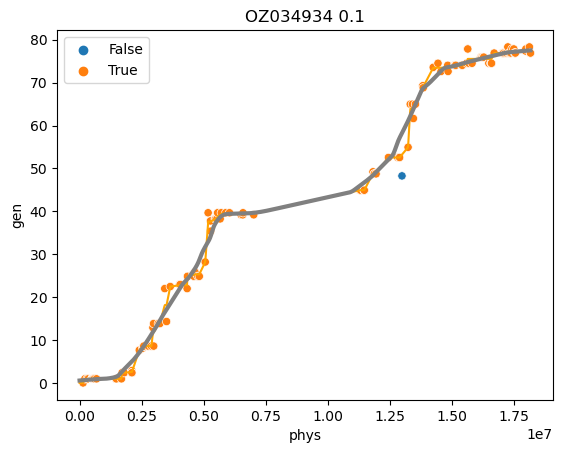

In [482]:
apal_smoothed = pd.DataFrame()
for i in apal["map"].unique():
    tmp = apal[apal["map"] == i][apal["vld"] == True].reset_index(drop=True)
    ir = IsotonicRegression()
    ir.fit(tmp["phys"], tmp["gen"])
    tmp["fitted"] = ir.predict(tmp["phys"])
    dummyx = np.linspace(0, tmp["phys"].max(), num=1000)
    dummyx = np.round(dummyx, 0)
    dummyy = ir.predict(dummyx)
    dummy = pd.DataFrame()
    dummy["phys"] = dummyx
    dummy["gen"] = dummyy
    dummy = dummy.fillna(0)
    lowess_smooth_link(dummy, "gen")
    dummy["chr"] = i
    plt.figure()
    sns.scatterplot(data = apal[apal["map"] == i].reset_index(drop=True), x = "phys", y = "gen", hue = "vld")
    sns.lineplot(data = dummy, x = "phys", y = "gen", color = "orange") #This is the data straight out of the isotonic regression prediction
    sns.lineplot(data = dummy, x = "phys", y = "smoothed_gen", color = "grey", lw = 3) #This is the smoothed output from the isotonic regression
    plt.title(i + " " + str(dummy["lowess_smoothing_fraction_gen"][0]))
    apal_smoothed = pd.concat([apal_smoothed, dummy]).reset_index(drop=True)

In [483]:
apal_smoothed["phys"] = apal_smoothed["phys"].astype(int)
apal_smoothed["mkr_name"] = "ps" + apal_smoothed["phys"].astype(str)

In [484]:
apal_smoothed[["chr", "mkr_name", "smoothed_gen", "phys"]].to_csv("../linkage_map/apal_linkage.map", 
                                                                  header = None, index = False, sep = "\t")